In [1]:
import numpy as np
np.random.seed(0)

from scipy.io import loadmat

import matplotlib.pyplot as plt
%matplotlib inline

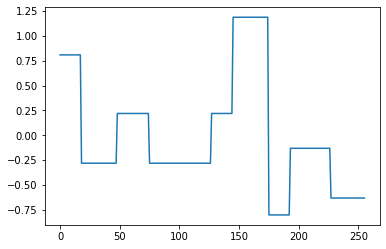

In [2]:
x = loadmat('x.mat')['x']

plt.plot(x)

In [3]:
m, n = 64, 256
e_var = 0.1 # noise variance

A = np.random.randn(m, n) / np.sqrt(m)
e = np.random.randn(m, 1) * e_var
# e = np.random.rand(m, 1) * 0.2 - 0.1

In [4]:
def func_piecewise_constant(n=256, k=8):
    """
    generate piecewise constant signal with k jumps
    k < n / 10
    k < m / 5
    """
    x = np.zeros((n, 1))
    w = (n - 16) // k
    for i in range(k):
        j = 8 + i * w + np.random.randint(1, w + 1)
        xj = np.random.randn(1)
        x[j] = np.sign(xj) * max(abs(xj), 1 / 2)

    x = np.cumsum(x, axis=0)
    x -= x.mean(axis=0)
    return x

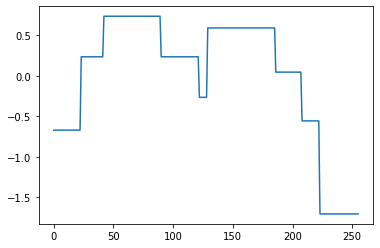

In [5]:
x = func_piecewise_constant()
plt.plot(x)

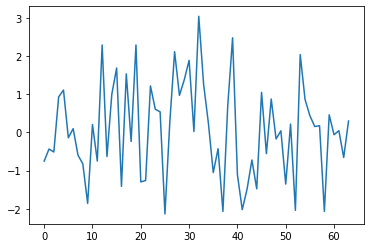

In [6]:
b = A @ x + e
plt.plot(b)

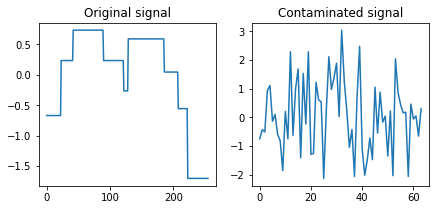

In [42]:
fig, (a1, a2) = plt.subplots(1, 2, figsize = (7, 3))

a1.plot(x)
a1.set_title('Original signal')

a2.plot(b)
a2.set_title('Contaminated signal')
plt.savefig('img/task1.pdf')

In [7]:
nabla = np.zeros((n, n)) # discrete gradient operator 1d
for i in range(n - 1):
    nabla[i, i] = -1
    nabla[i, i + 1] = 1

nabla

array([[-1.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0., -1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0., -1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -1.,  1.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [8]:
def h1(x, ita):
    nabla_x = np.diff(x, axis=0, append=x[-1, 0])
    cond = np.abs(nabla_x) >= ita
    return (np.abs(nabla_x[cond]) - ita / 2).sum() + (nabla_x[~cond] ** 2 / (2 * ita)).sum()
    
def h2(x):
    nabla_x = np.diff(x, axis=0, append=x[-1, 0])
    return nabla_x.T @ nabla_x

def Phi(x, A, b, h='1', mu=1, ita=1):
    """
    x.shape: (n, 1)
    """
    if h == '1':
        h = h1(x, ita)
    elif h == '2':
        h = h2(x)
        
    f = 1 / 2 * (A @ x - b).T @ (A @ x - b)
        
    return mu * h + f

In [9]:
Phi(x, A, b)

array([[2.35587653]])

In [10]:
nablaT_nabla = nabla.T @ nabla

def h1_grad(x, ita):
    nabla_x = np.diff(x, axis=0, append=x[-1, 0])
    cond = np.abs(nabla_x) >= ita
    
    h_grad_nbl_x = np.zeros_like(x)
    h_grad_nbl_x[cond] = np.sign(nabla_x[cond])
    h_grad_nbl_x[~cond] = nabla_x[~cond] / ita
    
    h_grad_x = nabla.T @ h_grad_nbl_x
    return h_grad_x
    
def h2_grad(x):
    return 2 * nablaT_nabla @ x

def Phi_grad(x, A, b, h='1', mu=1, ita=1):
    if h == '1':
        h_grad = h1_grad(x, ita)
    elif h == '2':
        h_grad = h2_grad(x)
        
    f_grad = A.T @ (A @ x - b)
    
    return mu * h_grad + f_grad

Phi_grad(x, A, b).shape

(256, 1)

0.020728429304066744
0 [[90.4570744]]
1000 [[1.6923233]]
2000 [[0.92759934]]
3000 [[0.70331825]]
4000 [[0.63474782]]
5000 [[0.62095465]]
6000 [[0.61941413]]
7000 [[0.61930592]]


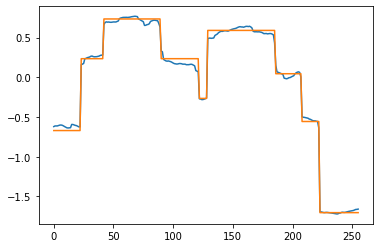

In [11]:
# train, Lipschitz constant L, step size

def get_Lip_const(A, mu=1, ita=1, h='1'):
    if h == '1':
        L = 4 * mu / ita + np.linalg.norm(A.T @ A, ord=2)
    elif h == '2':
        L = 8 * mu + np.linalg.norm(A.T @ A, ord=2)
    return L

H = '1'
MU = 0.1
ITA = 0.01

L = get_Lip_const(A, h=H, mu=MU, ita=ITA)

# y = x.copy() * 2
y = np.random.rand(*x.shape)
lr = 1 / L
print(lr)

prev_Phi = np.inf
criterion = 1e-8
for i in range(10000):
    y -= lr * Phi_grad(y, A, b, h=H, mu=MU, ita=ITA)
    curr_Phi = Phi(y, A, b, h=H, mu=MU, ita=ITA)
    if np.abs(prev_Phi - curr_Phi) < criterion:
        break
    prev_Phi = curr_Phi
    
    # verbose print
    if i % 1000 == 0:
        print(i, curr_Phi)
plt.plot(y)
plt.plot(x)

lr = 0.020728429304066744
0 [[90.3443238]]
1000 [[1.61521564]]
2000 [[0.89761815]]
3000 [[0.69780492]]
4000 [[0.63360405]]
5000 [[0.6208153]]
6000 [[0.61940105]]
7000 [[0.61930534]]


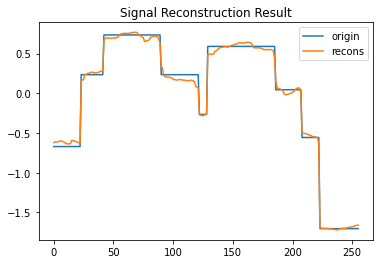

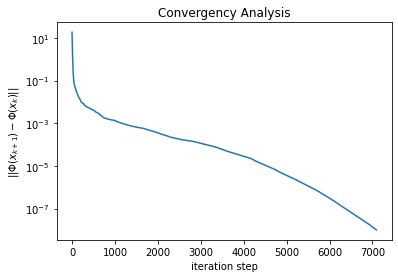

In [12]:
H = '1'
MU = 0.1
ITA = 0.01

def GD(A=A, mu=MU, ita=ITA, h=H, criterion=1e-8):
    def get_Lip_const(A, mu=1, ita=1, h='1'):
        if h == '1':
            L = 4 * mu / ita + np.linalg.norm(A.T @ A, ord=2)
        elif h == '2':
            L = 8 * mu + np.linalg.norm(A.T @ A, ord=2)
        return L

    L = get_Lip_const(A, h=H, mu=MU, ita=ITA)
    lr = 1 / L
    print(f'lr = {lr}')

    # init
    y = np.random.rand(*x.shape)
    
    # opt
    Phi_change_log = []
    prev_Phi = Phi(y, A, b, h=H, mu=MU, ita=ITA)
    for i in range(10000):
        y -= lr * Phi_grad(y, A, b, h=H, mu=MU, ita=ITA)
        curr_Phi = Phi(y, A, b, h=H, mu=MU, ita=ITA)
        
        Phi_change_log.append(np.abs(prev_Phi - curr_Phi).item())
        if np.abs(prev_Phi - curr_Phi) < criterion:
            break
        prev_Phi = curr_Phi

        # verbose print
        if i % 1000 == 0:
            print(i, curr_Phi)
    
    return y, Phi_change_log
        
y, log_gd = GD()

plt.plot(x, label='origin')
plt.plot(y, label='recons')
plt.legend()
plt.title("Signal Reconstruction Result")
plt.show()

plt.plot(log_gd)
plt.yscale('log')
plt.title("Convergency Analysis")
plt.xlabel("iteration step")
plt.ylabel("$||\Phi(x_{k + 1}) - \Phi(x_{k})||$")
plt.show()

lr = 0.020728429304066744
0 [[95.30290197]]
1000 [[0.89127041]]
2000 [[0.63173122]]
3000 [[0.61938215]]


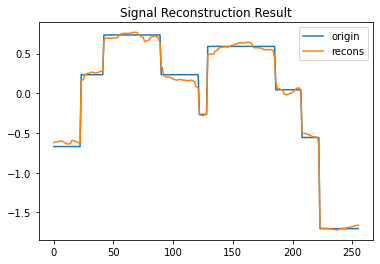

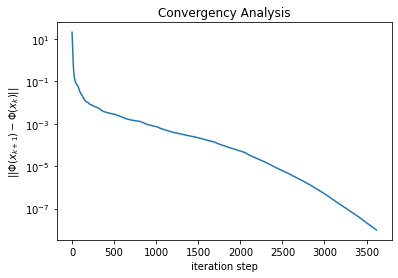

In [13]:
H = '1'
MU = 0.1
ITA = 0.01

def Nesterov(A=A, mu=MU, ita=ITA, h=H, criterion=1e-8):
    def get_Lip_const(A, mu=1, ita=1, h='1'):
        if h == '1':
            L = 4 * mu / ita + np.linalg.norm(A.T @ A, ord=2)
        elif h == '2':
            L = 8 * mu + np.linalg.norm(A.T @ A, ord=2)
        return L

    L = get_Lip_const(A, h=h, mu=mu, ita=ita)
    lr = 1 / L
    print(f'lr = {lr}')

    # init
    y = np.random.rand(*x.shape)
    
    # opt
    Phi_change_log = []
    prev_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)
    prev_Phi_grad = 0
    for i in range(10000):
        # Nesterov momentum
        a = (i - 1) / (i + 2)
        y -= a * lr * prev_Phi_grad
        
        y -= lr * Phi_grad(y, A, b, h=h, mu=mu, ita=ita)
        curr_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)
        
        Phi_change_log.append(np.abs(prev_Phi - curr_Phi).item())
        if np.abs(prev_Phi - curr_Phi) < criterion:
            break
        prev_Phi = curr_Phi
        prev_Phi_grad = Phi_grad(y, A, b, h=h, mu=mu, ita=ita)

        # verbose print
        if i % 1000 == 0:
            print(i, curr_Phi)
    
    return y, Phi_change_log
        
y, log_nes = Nesterov()

plt.plot(x, label='origin')
plt.plot(y, label='recons')
plt.legend()
plt.title("Signal Reconstruction Result")
plt.show()

plt.plot(log_nes)
plt.yscale('log')
plt.title("Convergency Analysis")
plt.xlabel("iteration step")
plt.ylabel("$||\Phi(x_{k + 1}) - \Phi(x_{k})||$")
plt.show()

0 [[1.2879754]]


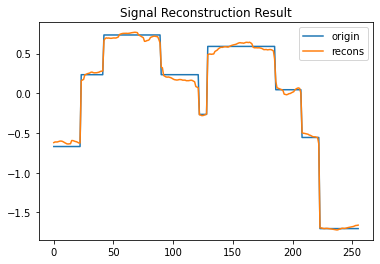

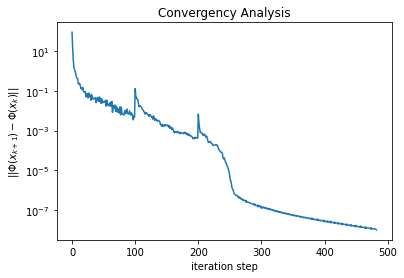

In [15]:
H = '1'
MU = 0.1
ITA = 0.01

def ConjugateGradient(A=A, mu=MU, ita=ITA, h=H, criterion=1e-8):

    # init
    y = np.random.rand(*x.shape)
    
    def backtracking_ls(curr_x, curr_g, curr_d, beta=0.9):
        delta = 1 / 3
        step_size = 1
        while Phi(curr_x + step_size * curr_d, A, b, h=h, mu=mu, ita=ita) \
            > Phi(curr_x, A, b, h=h, mu=mu, ita=ita) + delta * step_size * (curr_g * curr_d).sum():
            step_size *= beta
        return step_size
    
    # opt
    Phi_change_log = []
    prev_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)
    prev_g = Phi_grad(y, A, b, h=h, mu=mu, ita=ita)
    prev_d = -prev_g
    for _ in range(100):
        for i in range(100):
            g = Phi_grad(y, A, b, h=h, mu=mu, ita=ita)
            
            beta = (g ** 2).sum() / ((prev_g ** 2).sum() + 1e-4)
#             beta = (g.T @ (g - prev_g)) / (prev_d.T @ (g - prev_g) + 1e-3)
            if i == 0:
                d = -g
            else:
                d = -g + beta * prev_d
            step_size = backtracking_ls(y, g, d)
            y += step_size * d

            curr_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)

            Phi_change_log.append(np.abs(prev_Phi - curr_Phi).item())
            if np.abs(prev_Phi - curr_Phi) < criterion:
                return y, Phi_change_log
            
            prev_Phi = curr_Phi
            prev_g = g
            prev_d = d

        # verbose print
        if _ % 10 == 0:
#             print(step_size, beta, np.linalg.norm(g), curr_Phi)
            print(_, curr_Phi)
            

    return y, Phi_change_log
        
y, log_con_b1 = ConjugateGradient()

plt.plot(x, label='origin')
plt.plot(y, label='recons')
plt.legend()
plt.title("Signal Reconstruction Result")
plt.show()

plt.plot(log_con_b1)
plt.yscale('log')
plt.title("Convergency Analysis")
plt.xlabel("iteration step")
plt.ylabel("$||\Phi(x_{k + 1}) - \Phi(x_{k})||$")
plt.show()

0 [[0.63780748]]


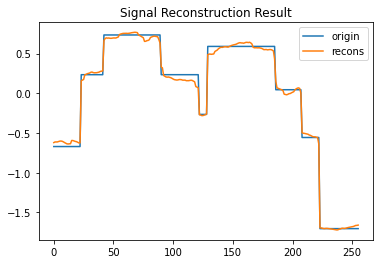

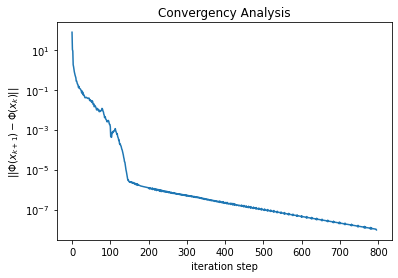

In [16]:
H = '1'
MU = 0.1
ITA = 0.01

def ConjugateGradient(A=A, mu=MU, ita=ITA, h=H, criterion=1e-8):

    # init
    y = np.random.rand(*x.shape)
    
    def backtracking_ls(curr_x, curr_g, curr_d, beta=0.9):
        delta = 1 / 3
        step_size = 1
        while Phi(curr_x + step_size * curr_d, A, b, h=h, mu=mu, ita=ita) \
            > Phi(curr_x, A, b, h=h, mu=mu, ita=ita) + delta * step_size * (curr_g * curr_d).sum():
            step_size *= beta
        return step_size
    
    # opt
    Phi_change_log = []
    prev_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)
    prev_g = Phi_grad(y, A, b, h=h, mu=mu, ita=ita)
    prev_d = -prev_g
    for _ in range(100):
        for i in range(100):
            g = Phi_grad(y, A, b, h=h, mu=mu, ita=ita)
            
#             beta = (g ** 2).sum() / ((prev_g ** 2).sum() + 1e-4)
            beta = (g.T @ (g - prev_g)) / (prev_d.T @ (g - prev_g) + 1e-3)
            if i == 0:
                d = -g
            else:
                d = -g + beta * prev_d
            step_size = backtracking_ls(y, g, d)
            y += step_size * d

            curr_Phi = Phi(y, A, b, h=h, mu=mu, ita=ita)

            Phi_change_log.append(np.abs(prev_Phi - curr_Phi).item())
            if np.abs(prev_Phi - curr_Phi) < criterion:
                return y, Phi_change_log
            
            prev_Phi = curr_Phi
            prev_g = g
            prev_d = d

        # verbose print
        if _ % 10 == 0:
#             print(step_size, beta, np.linalg.norm(g), curr_Phi)
            print(_, curr_Phi)
            

    return y, Phi_change_log
        
y, log_con_b2 = ConjugateGradient()

plt.plot(x, label='origin')
plt.plot(y, label='recons')
plt.legend()
plt.title("Signal Reconstruction Result")
plt.show()

plt.plot(log_con_b2)
plt.yscale('log')
plt.title("Convergency Analysis")
plt.xlabel("iteration step")
plt.ylabel("$||\Phi(x_{k + 1}) - \Phi(x_{k})||$")
plt.show()

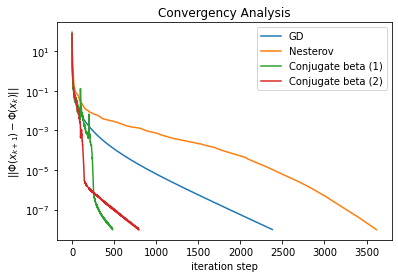

In [30]:
plt.plot(log_gd, label='GD')
plt.plot(log_nes, label='Nesterov')
plt.plot(log_con_b1, label='Conjugate beta (1)')
plt.plot(log_con_b2, label='Conjugate beta (2)')
plt.legend()
plt.yscale('log')
plt.title("Convergency Analysis")
plt.xlabel("iteration step")
plt.ylabel("$||\Phi(x_{k + 1}) - \Phi(x_{k})||$")
plt.savefig('img/convergency.pdf')

In [35]:
MU = 0.1
y1, _ = Nesterov(mu=MU, ita=0.01, h='1')
y2, _ = Nesterov(mu=MU, ita=1, h='1')
y3, _ = Nesterov(mu=MU, ita=ITA, h='2')


lr = 0.020728429304066744
0 [[80.90124946]]
1000 [[0.87637333]]
2000 [[0.63088017]]
3000 [[0.61937538]]
lr = 0.11570160987069311
0 [[25.12203165]]
1000 [[0.06458494]]
2000 [[0.05749567]]
3000 [[0.0570893]]
lr = 0.1105837239175886
0 [[29.81043036]]
1000 [[0.11267433]]
2000 [[0.1113685]]


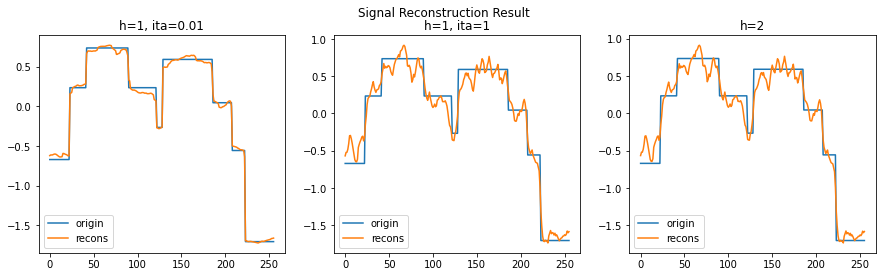

In [36]:

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 4))
a1.plot(x, label='origin')
a1.plot(y1, label='recons')
a1.legend()
a1.set_title('h=1, ita=0.01')
a2.plot(x, label='origin')
a2.plot(y2, label='recons')
a2.legend()
a2.set_title('h=1, ita=1')
a3.plot(x, label='origin')
a3.plot(y3, label='recons')
a3.legend()
a3.set_title('h=2')
plt.suptitle("Signal Reconstruction Result")
plt.savefig('img/h1_h2_ita.pdf')

In [31]:

y1, _ = Nesterov(mu=0.01, ita=0.01, h='1')
y2, _ = Nesterov(mu=0.1, ita=0.01, h='1')
y3, _ = Nesterov(mu=1, ita=0.01, h='1')


lr = 0.08167984673165492
0 [[36.11969011]]
1000 [[0.21192018]]
2000 [[0.11700509]]
3000 [[0.08682106]]
4000 [[0.07470265]]
5000 [[0.07168798]]
6000 [[0.07078812]]
7000 [[0.07060605]]
8000 [[0.07057564]]
lr = 0.020728429304066744
0 [[89.68311909]]
1000 [[0.94422378]]
2000 [[0.63681593]]
3000 [[0.61943889]]
lr = 0.002449521953439546
0 [[173.12660703]]
1000 [[6.80161355]]
2000 [[4.99275404]]
3000 [[4.73814061]]
4000 [[4.6977195]]
5000 [[4.6925625]]
6000 [[4.69183764]]
7000 [[4.69173145]]


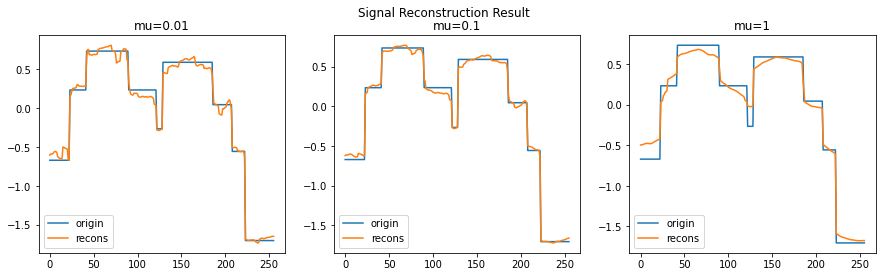

In [34]:

fig, (a1, a2, a3) = plt.subplots(1, 3, figsize=(15, 4))
a1.plot(x, label='origin')
a1.plot(y1, label='recons')
a1.legend()
a1.set_title('mu=0.01')
a2.plot(x, label='origin')
a2.plot(y2, label='recons')
a2.legend()
a2.set_title('mu=0.1')
a3.plot(x, label='origin')
a3.plot(y3, label='recons')
a3.legend()
a3.set_title('mu=1')
plt.suptitle("Signal Reconstruction Result")
plt.savefig('img/mu.pdf')